In [1]:
import xarray as xr
import datetime as dt
import numpy as np
import glob
from barpa_read import drop_duplicates
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pandas as pd


In [32]:
#Files created within resample_lightning.py
barpa = xr.open_dataset("/g/data/eg3/ab4502/regridded_lightning/barpa.nc").rename({"longitude_bins":"lon","latitude_bins":"lat"})
wwlln = xr.open_dataset("/g/data/eg3/ab4502/regridded_lightning/wwlln.nc")

In [33]:
def draw_gridlines(ax):
    g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False
    g.xlabel_style={"size":12}
    g.ylabel_style={"size":12}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER         



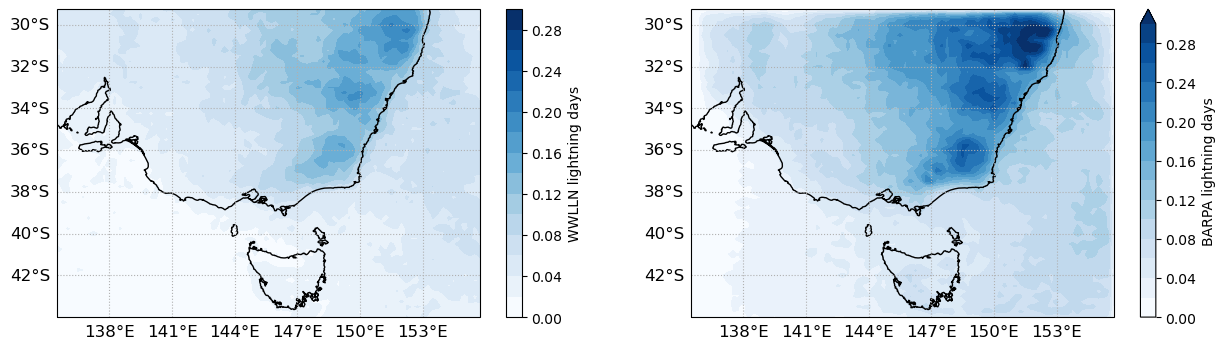

In [53]:
wwlln_days = len(wwlln.Lightning_observed.original_times)
barpa_days = len(barpa.n_lightning_fl.original_times)


plt.figure(figsize=[15,4])
ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
c=xr.plot.contourf(wwlln.Lightning_observed / wwlln_days,levels=np.arange(0,0.32,0.02),cmap="Blues",add_colorbar=False)
cb=plt.colorbar(c)
cb.set_label("WWLLN lightning days")
ax.coastlines()
draw_gridlines(ax)

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
c=xr.plot.contourf(barpa.n_lightning_fl / barpa_days,levels=np.arange(0,0.32,0.02),cmap="Blues",add_colorbar=False)
cb=plt.colorbar(c)
cb.set_label("BARPA lightning days")
ax.coastlines()
draw_gridlines(ax)

plt.savefig("/g/data/eg3/ab4502/figs/barpa/lightning.jpeg",dpi=400,bbox_inches="tight")